## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

#os.makedirs('data/planet/models', exist_ok=True)
#os.makedirs('cache/planet/tmp', exist_ok=True)

#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
#!ln -s /cache/planet/tmp {PATH}

ln: failed to create symbolic link 'data/planet/train-jpg': File exists
ln: failed to create symbolic link 'data/planet/test-jpg': File exists
ln: failed to create symbolic link 'data/planet/train_v2.csv': File exists


In [6]:
ls {PATH}

models/                    test-jpg-additional/       train-jpg/
sample_submission_v2.csv*  test_v2_file_mapping.csv*  train-tif-v2/
test-jpg/                  tmp/                       train_v2.csv*


## Multi-label versus single-label classification

In [7]:
from fastai.plots import *

In [8]:
def get_1st(path): return glob(f'{path}/*.*')[0]

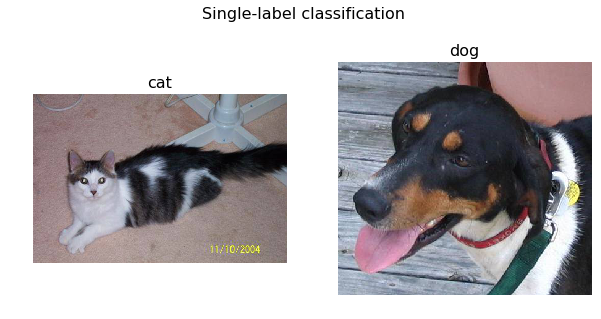

In [9]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

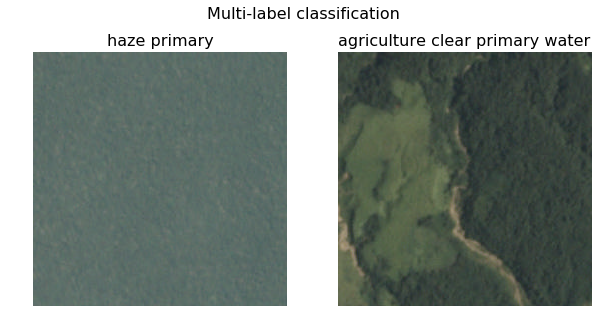

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [11]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [12]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [13]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [14]:
print(val_idxs[:10])

[34602 11243 14499 18918 30631 21503 39602 27556 19889 31739]


In [15]:
data = get_data(256)

In [16]:
x,y = next(iter(data.val_dl))

In [17]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [18]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

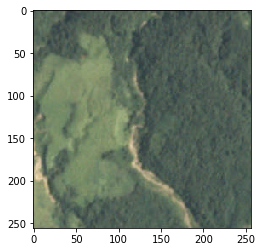

In [19]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [21]:
sz=64

In [22]:
data = get_data(sz)

In [23]:
data = data.resize(int(sz*1.3), 'tmp')

In [24]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.221055   0.352584   0.733505  



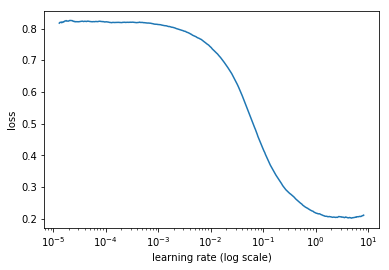

In [25]:
lrf=learn.lr_find()
learn.sched.plot()

In [26]:
lr = 0.2

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.146614   0.134374   0.882583  
    1      0.139715   0.129907   0.885915                    
    2      0.140594   0.126886   0.889947                    
    3      0.138217   0.126397   0.890101                    
    4      0.13553    0.125074   0.890561                    
    5      0.132024   0.123386   0.892691                    
    6      0.131107   0.123102   0.892203                    



[array([0.1231]), 0.892203486888238]

In [28]:
lrs = np.array([lr/9,lr/3,lr])

In [29]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.119125   0.11071    0.906321  
    1      0.118506   0.107546   0.909129                    
    2      0.108636   0.102064   0.914955                    
    3      0.110883   0.103906   0.913302                    
    4      0.108757   0.101176   0.915413                    
    5      0.099839   0.097486   0.917154                     
    6      0.101451   0.097588   0.91761                      



[array([0.09759]), 0.9176096711631834]

In [30]:
learn.save(f'{sz}')

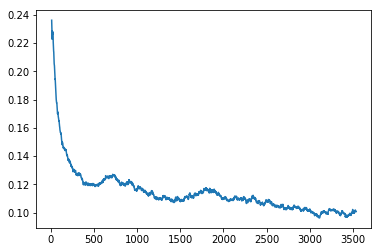

In [31]:
learn.sched.plot_loss()

In [32]:
sz=128

In [33]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.097579   0.097386   0.917156  
    1      0.097569   0.096504   0.917603                     
    2      0.098719   0.095287   0.918116                     
    3      0.096772   0.095691   0.917614                     
    4      0.095329   0.09423    0.919701                     
    5      0.094097   0.094148   0.91926                      
    6      0.096496   0.09363    0.919301                     



[array([0.09363]), 0.9193010705904486]

In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.096335   0.088701   0.926072  
    1      0.095937   0.088217   0.926571                     
    2      0.091398   0.087151   0.926406                     
    3      0.088417   0.08913    0.924848                     
    4      0.088804   0.086974   0.92715                      
    5      0.085582   0.08545    0.92872                      
    6      0.08206    0.085145   0.928418                     



In [35]:
sz=256

In [36]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.092211   0.089288   0.924362  
    1      0.089941   0.088534   0.924351                     
    2      0.091582   0.088033   0.926033                     
    3      0.089425   0.087452   0.926346                     
    4      0.088871   0.087572   0.926359                     
    5      0.0873     0.087664   0.926019                     
    6      0.086611   0.087784   0.925737                     



[array([0.08778]), 0.925737338996257]

In [37]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.088402   0.083071   0.931223  
    1      0.08584    0.08464    0.930677                     
    2      0.082991   0.082259   0.931778                     
    3      0.087337   0.085538   0.926893                     
    4      0.083689   0.083097   0.932035                     
    5      0.079768   0.082448   0.930848                     
    6      0.078249   0.081941   0.932179                     



In [38]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [39]:
f2(preds,y)

0.9305164502515171

### End